# CIFAR 100 using Transfer Learning (Inceptionv3)

# Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization,GlobalAveragePooling2D,UpSampling2D

# Importing the Cifar 100 Dataset


In [ ]:
cifar10 = tf.keras.datasets.cifar100
(X_train, Y_train), (X_test,Y_test) = cifar10.load_data()

# Plotting some images

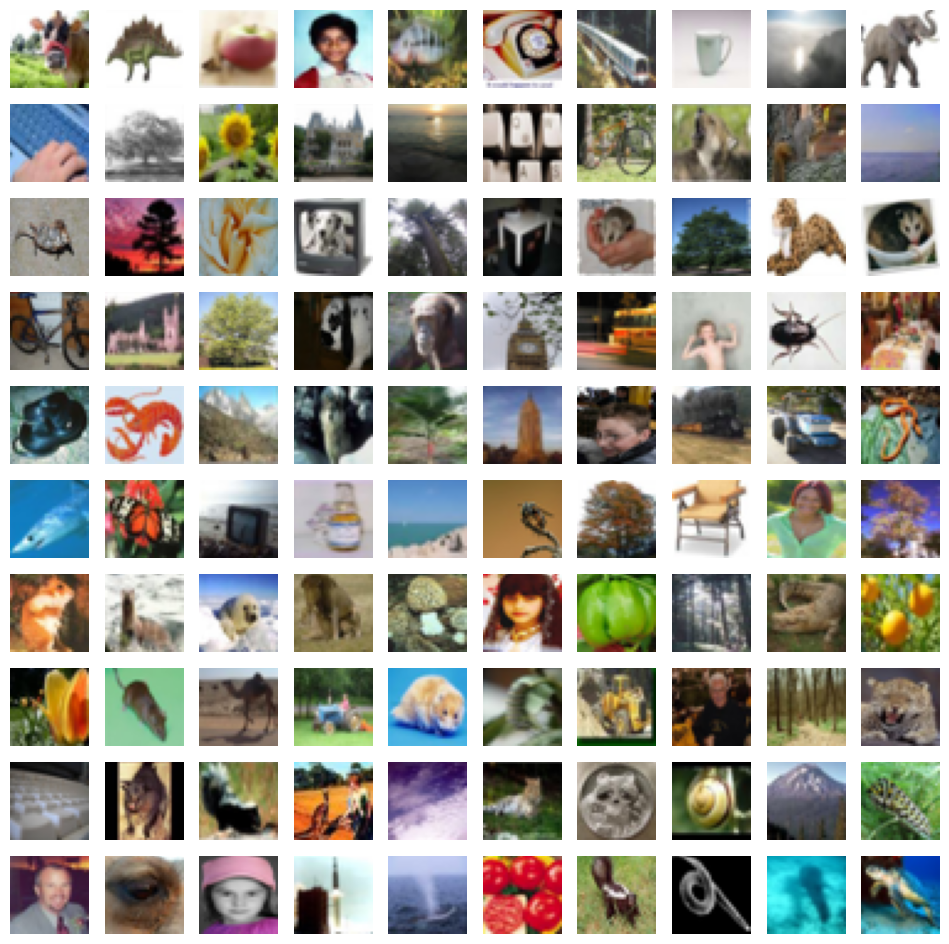

In [ ]:
plt.figure(figsize=(12,12))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(X_train[i],cmap='gray')

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X_train, Y_train,test_size=0.2)

# Onehot encoding of the outputs


In [ ]:
from keras.utils import to_categorical
y_train=to_categorical(y_train,num_classes=100)
y_val=to_categorical(y_val,num_classes=100)
y_test=to_categorical(Y_test,num_classes=100)

In [ ]:
x_train = x_train*1.0/255
x_val = x_val*1.0/255
X_test = X_test*1.0/255

In [ ]:
print(x_train.shape,x_val.shape,X_test.shape)
print(y_train.shape,y_val.shape,y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


# Image Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
        )
train_datagen.fit(x_train)

# Reduce Learning Rate if accuracy is not improving for 3 epochs

In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.6,
    min_lr=1e-6)

# Importing the Inceptionv3 Model

In [ ]:
from tensorflow.keras.applications import InceptionV3
inception_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

for layer in inception_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
inception_model.summary()

In [ ]:
model=tf.keras.models.Sequential()
model.add(UpSampling2D(size=(7, 7),interpolation='bilinear'))
model.add(inception_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='softmax'))


In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)

In [ ]:
model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
result=model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 128),
    validation_data = (x_val, y_val),
    epochs = 50,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)


Epoch 1/50
313/313 [==============================] - 252s 737ms/step - loss: 2.8684 - accuracy: 0.3261 - val_loss: 1.7208 - val_accuracy: 0.5408 - lr: 0.0100
Epoch 2/50
313/313 [==============================] - 207s 660ms/step - loss: 1.7915 - accuracy: 0.5214 - val_loss: 1.4488 - val_accuracy: 0.5922 - lr: 0.0100
Epoch 3/50
313/313 [==============================] - 207s 662ms/step - loss: 1.5049 - accuracy: 0.5847 - val_loss: 1.2880 - val_accuracy: 0.6434 - lr: 0.0100
Epoch 4/50
313/313 [==============================] - 207s 662ms/step - loss: 1.3645 - accuracy: 0.6168 - val_loss: 1.1855 - val_accuracy: 0.6624 - lr: 0.0100
Epoch 5/50
313/313 [==============================] - 207s 662ms/step - loss: 1.2613 - accuracy: 0.6409 - val_loss: 1.1377 - val_accuracy: 0.6717 - lr: 0.0100
Epoch 6/50
313/313 [==============================] - 206s 660ms/step - loss: 1.1787 - accuracy: 0.6612 - val_loss: 1.0765 - val_accuracy: 0.6848 - lr: 0.0100
Epoch 7/50
313/313 [==========================

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2  (None, None, None, None   0         
 D)                          )                                   
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_94 (Ba  (None, 256)               1

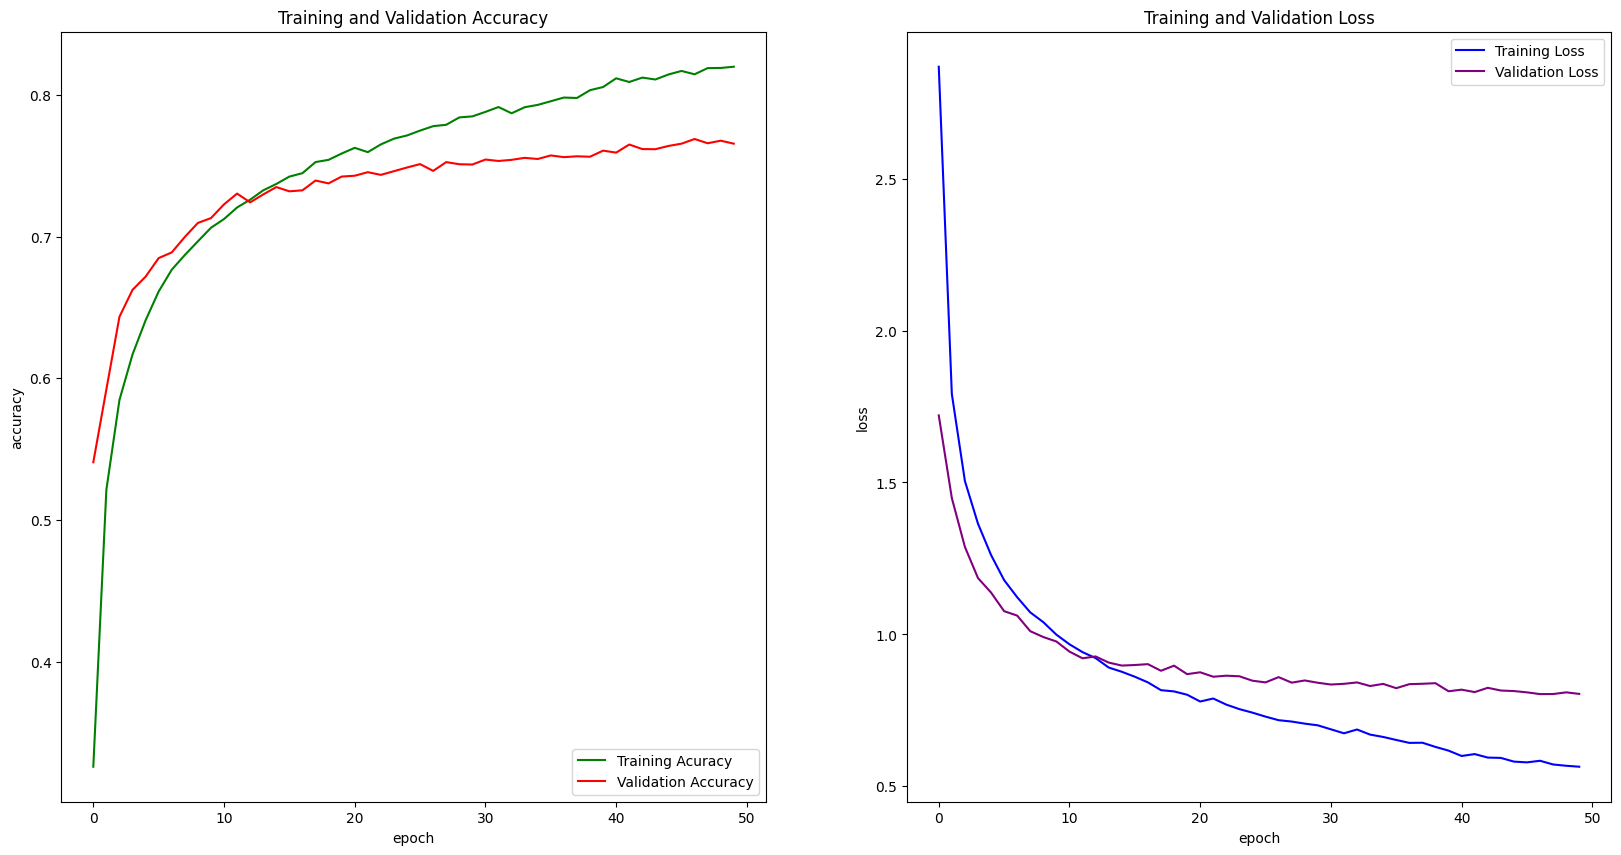

In [ ]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']
loss = result.history['loss']
val_loss = result.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Training and Validation Accuracy")
plt.plot(acc,color = 'green',label = 'Training Acuracy')
plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.subplot(1, 2, 2)
plt.title('Training and Validation Loss')
plt.plot(loss,color = 'blue',label = 'Training Loss')
plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# Predictions,Accuracy and Confusion Matrix

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = Y_test.ravel()
print(y_pred.shape,y_true.shape)

313/313 [==============================] - 21s 62ms/step
(10000,) (10000,)


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

print("Testing Accuracy: ", accuracy_score(y_true,y_pred))

Testing Accuracy:  0.7692


In [ ]:
cm = confusion_matrix(y_true,y_pred)
cm

array([[96,  0,  0, ...,  0,  0,  0],
       [ 0, 79,  0, ...,  0,  0,  0],
       [ 0,  0, 67, ...,  0,  1,  0],
       ...,
       [ 0,  0,  0, ..., 86,  0,  0],
       [ 0,  0,  3, ...,  0, 57,  0],
       [ 0,  0,  0, ...,  0,  0, 79]])

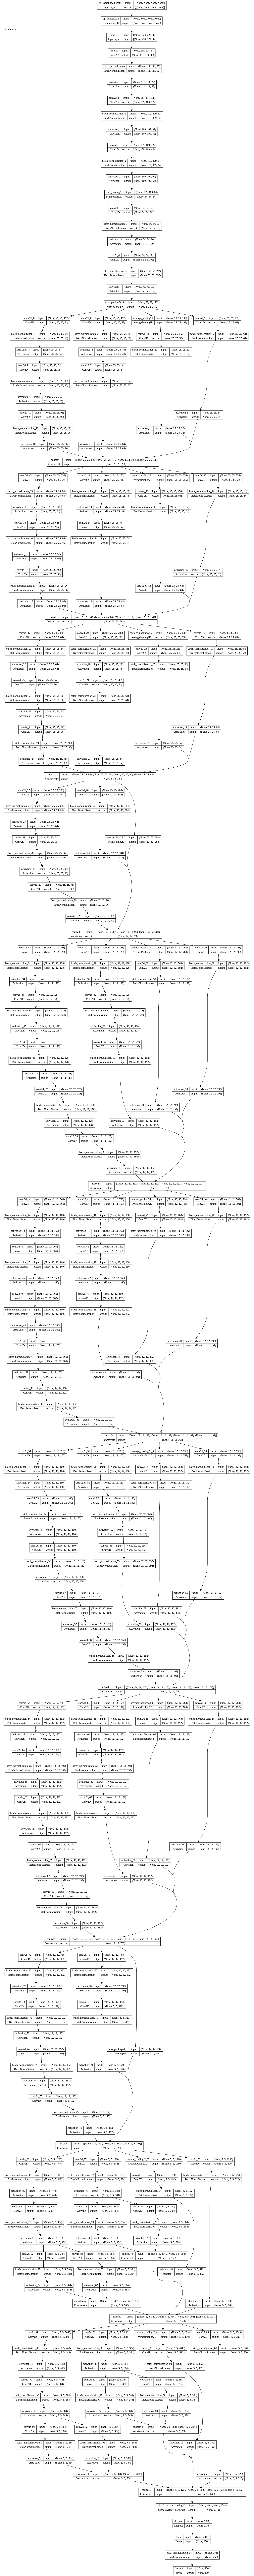

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,expand_nested=True)